In [3]:
import sys
import os
import re
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import pathlib

base_dir = pathlib.Path().resolve().parent
sys.path.append(str(base_dir))

# Import functions
from RetroChem.Package_functions.Model_training_functions import prepare_fingerprints_for_training

#Path to the data directory
data_dir = base_dir / "RetroChem" / "Data"

paths = {
    "train": data_dir / "reaction_templates_50k_train.csv",
    "valid": data_dir / "reaction_templates_50k_valid.csv",
    "test":  data_dir / "reaction_templates_50k_test.csv"
}

# Required columns in input data
required_cols = ['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash']

dfs = []

# Load and validate files
for name, path in paths.items() :
    try:
        df = pd.read_csv(path, sep="\t")
        df.columns = df.columns.str.strip()

        missing_cols = set(required_cols) - set(df.columns)
        if missing_cols:
            print(f"⚠️  Missing columns in {name}: {missing_cols}")
            continue

        dfs.append(df[required_cols])
        print(f"✅ {name} loaded successfully. Rows: {len(df)}")

    except Exception as e:
        print(f"❌ Error loading {name}: {e}")

# Step 7: Merge and save combined data
if dfs:
    combined_df = pd.concat(dfs, axis=0).drop_duplicates(subset=['PseudoHash'])
    combined_path = data_dir / "combined_data.csv"
    combined_df.to_csv(combined_path, index=False, sep="\t")
    print(f"✅ Merged data saved to: {combined_path}")
else:
    print("❌ No valid files to merge.")

# Step 8: Load the merged file and check columns
combined_df = pd.read_csv(data_dir / "combined_data.csv", sep="\t")
combined_df.columns = combined_df.columns.str.strip()
print(f"🧾 Columns in combined_df: {combined_df.columns.tolist()}")



✅ train loaded successfully. Rows: 40008
✅ valid loaded successfully. Rows: 2717
✅ test loaded successfully. Rows: 5007
✅ Merged data saved to: C:\Users\flopi\Retrochem\RetroChem\Data\combined_data.csv
🧾 Columns in combined_df: ['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash']


📁 Step 1: Loading the dataset...
🔬 Step 3: Transforming data...
Start of data processing.
Index 0 - SMILES: CC(C)(C)OC(=O)[NH:1][C@H:2]([CH2:3][c:4]1[cH:5][nH:6][c:7]2[cH:8][cH:9][cH:10][cH:11][c:12]12)[c:13]1[n:14][c:15](-[c:16]2[cH:17][cH:18][c:19]([F:20])[cH:21][cH:22]2)[cH:23][nH:24]1>>[NH2:1][C@H:2]([CH2:3][c:4]1[cH:5][nH:6][c:7]2[cH:8][cH:9][cH:10][cH:11][c:12]12)[c:13]1[n:14][c:15](-[c:16]2[cH:17][cH:18][c:19]([F:20])[cH:21][cH:22]2)[cH:23][nH:24]1 | Target: b883d4425d6daa76b98d429b998b1a6ca9aa33cb964e8a98b8b7708b2a9601a3
Index 1 - SMILES: CS(=O)(=O)O[CH2:1][C:2]1([NH:3][C:4]([O:5][C:6]([CH3:7])([CH3:8])[CH3:9])=[O:10])[CH2:11][O:12][C:13]([CH3:14])([CH3:15])[O:16][CH2:17]1.[CH3:18][O:19][c:20]1[cH:21][cH:22][c:23]2[c:24]([C:25](=[O:26])[c:27]3[cH:28][c:29]([O:30][CH3:31])[c:32]([O:33][CH3:34])[c:35]([O:36][CH3:37])[cH:38]3)[cH:39][nH:40][c:41]2[cH:42]1>>[CH2:1]([C:2]1([NH:3][C:4]([O:5][C:6]([CH3:7])([CH3:8])[CH3:9])=[O:10])[CH2:11][O:12][C:13]([CH3:14])([CH3:15])[O:16][CH2:17]1

c:\Users\flopi\anaconda3\envs\env_projet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


✅ Model trained
📈 Validation accuracy: 0.0829
📉 Test accuracy: 0.0832


C:\Users\flopi\AppData\Local\Temp\ipykernel_18500\186155710.py:107: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\flopi\anaconda3\envs\env_projet\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


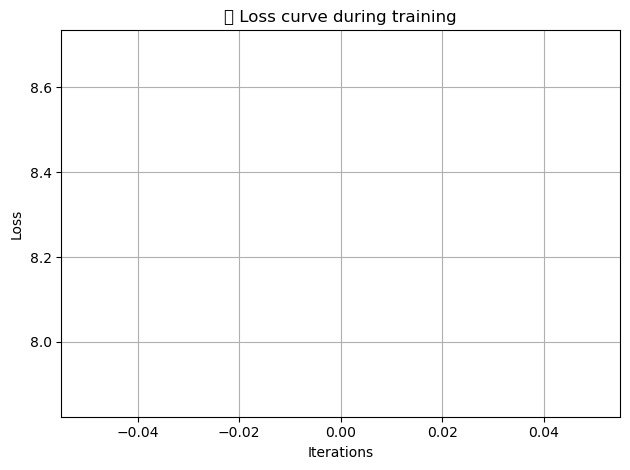

💾 New Model, scaler, and encoder saved successfully


In [7]:
import warnings
from rdkit import RDLogger

# Hide RDKit warnings for more readable output
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

# 1. Load the dataset
print("📁 Step 1: Loading the dataset...")
# Define the path to the data file
combined_file_path = os.path.join(data_dir, "combined_data.csv")

# Read the CSV file with tab separator
combined_df = pd.read_csv(combined_file_path, sep="\t")


# 2. Relevant columns
cols = ['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash']

# 3. Transform data into X and y
print("🔬 Step 3: Transforming data...")
X, y = prepare_fingerprints_for_training(combined_df)
print("✅ Step 4: Data transformed into X and y")

# 4. Encode y (if categorical labels are strings)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert string labels to integers if necessary

# Check and remove missing values in y
print("🔍 Checking for missing values in y...")
if np.any(np.isnan(y)):
    print("⚠️ Missing values found in y, removing corresponding rows...")
    mask_valid = ~np.isnan(y)
    X = X[mask_valid]
    y = y[mask_valid]

# 5. Split 70/15/15 (train/validation/test)
print("✂️ Step 5: Splitting data - 70% train, 15% validation, 15% test")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, temp_idx in sss.split(X, y):
    X_train, X_temp = X[train_idx], X[temp_idx]
    y_train, y_temp = y[train_idx], y[temp_idx]

# 6. Stratification only on frequent classes
# Identify rare classes with fewer than 2 samples
rare_classes = [class_ for class_, count in pd.Series(y_temp).value_counts().items() if count == 1]

# Select frequent classes (with at least 2 samples)
frequent_classes = [class_ for class_ in pd.Series(y_temp).value_counts().index if class_ not in rare_classes]

# Convert y_temp to pandas.Series for .isin()
y_temp_series = pd.Series(y_temp)

# Filter X_temp and y_temp to retain only frequent classes
mask_frequent = y_temp_series.isin(frequent_classes)
X_temp_filtered = X_temp[mask_frequent]
y_temp_filtered = y_temp[mask_frequent]

# 7. Stratify the filtered temporary set
print("🧹 Step 6: Stratifying the temporary set...")
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_idx, test_idx in sss_val_test.split(X_temp_filtered, y_temp_filtered):
    X_val, X_test = X_temp_filtered[val_idx], X_temp_filtered[test_idx]
    y_val, y_test = y_temp_filtered[val_idx], y_temp_filtered[test_idx]

# 8. Include rare classes in training without stratification
X_train = np.vstack([X_train, X_temp[~mask_frequent]])  # Add rare classes to training set
y_train = np.hstack([y_train, y_temp[~mask_frequent]])

print(f"📊 Dataset sizes: train={len(y_train)}, val={len(y_val)}, test={len(y_test)}")

# 9. Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("✅ Step 7: Data normalized")

# 10. Train model with early stopping
print("🚀 Step 8: Training the model with early stopping")
model = MLPClassifier(
    hidden_layer_sizes=(128, 128, 64),
    max_iter=40,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=True
)
model.fit(X_train_scaled, y_train)
print("✅ Model trained")

# 11. Evaluate on validation and test sets
acc_val = accuracy_score(y_val, model.predict(X_val_scaled))
acc_test = accuracy_score(y_test, model.predict(X_test_scaled))
print(f"📈 Validation accuracy: {acc_val:.4f}")
print(f"📉 Test accuracy: {acc_test:.4f}")

# 12. Loss curve
plt.plot(model.loss_curve_)
plt.title("📉 Loss curve during training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save new model, scaler, and encoder
joblib.dump(model, "new_mlp_classifier_model.pkl")
joblib.dump(scaler, "new_scaler.pkl")
joblib.dump(label_encoder,"new_label_encoder.pkl")

print("💾 New Model, scaler, and encoder saved successfully")